In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import util, draw, io, filters, color, exposure, transform, feature, segmentation, measure, morphology, draw, transform, filters, img_as_float, img_as_ubyte
from src import Simulator, Cell
import napari
import opensimplex
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10,10)

# Opensimplex noise approach

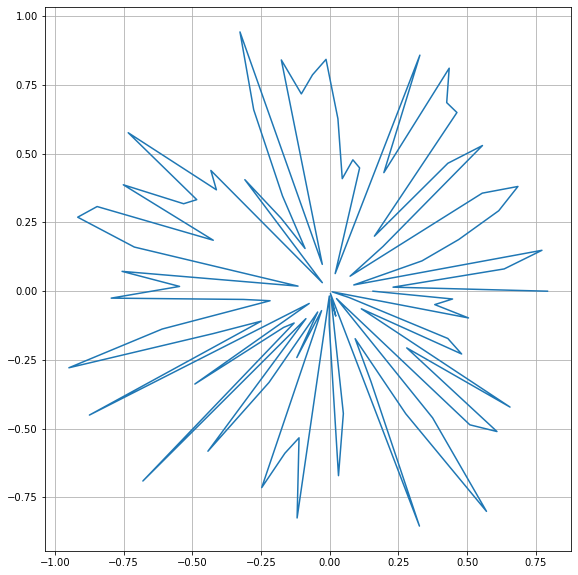

In [2]:
N = 100
l = np.zeros(N)
a = np.linspace(0,2*np.pi,N)
r = np.random.random(N)

x = r * np.cos(a)
y = r * np.sin(a)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_aspect('equal')
ax.plot(x,y)
ax.grid()





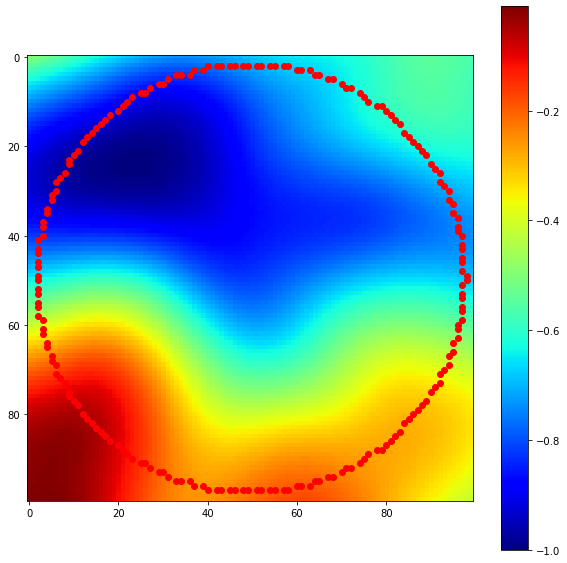

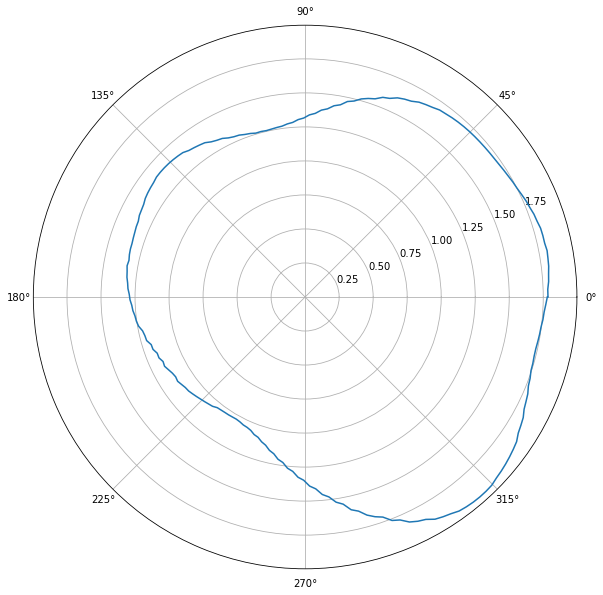

In [13]:
N = 100
A = np.zeros((N,N))
gamma = 1
for i in range(10):
    z = np.random.rand()*N*1.5
    x = np.linspace(z,z+i,N)
    y = x
    a = opensimplex.noise2array(x, y)*np.exp(-i*gamma)
    A += a

A /= np.abs(A).max()
from matplotlib import cm
plt.imshow(A, cmap=cm.jet)

c = N//2
a = np.linspace(0,2*np.pi,N*2)
r = N//2-2

x = (r * np.cos(a) + c).astype(int)
y = (r * np.sin(a) + c).astype(int)

plt.colorbar()
plt.scatter(x, y, c='r')
plt.show()

l = A[x, y]
L = np.ones_like(l)*2
L += l
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')
ax.plot(a, L)


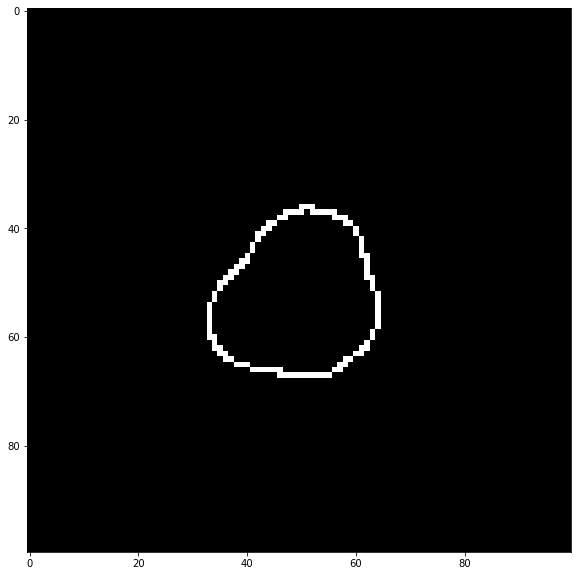

In [14]:
mask = np.zeros((100,100))
c = mask.shape[0]//2

i = (L*10 * np.cos(a) + c).astype(int)
j = (L*10 * np.sin(a) + c).astype(int)

mask[i,j] = 1
plt.figure(figsize=(10,10))
plt.imshow(mask)

## Refactor

In [ ]:
class NoiseBlob:
    def __init__(self, size):
        self.size = size

        self.mask = None
        self.texture = None

    def make_mask(self, gamma, circularity):
        contour, angular_span = self.generate_contour(gamma, circularity)
        self.mask = self.generate_blob(contour, angular_span).astype(bool)
        return self.mask

    def make_texture(self, gamma):
        if type(self.mask) == None: raise RuntimeError('Mask is not generated')
        self.texture = np.zeros(self.mask.shape)
        noise = self.generate_noise(self.mask.shape, gamma)
        noise -= noise.min()
        noise /= noise.max()
        self.texture[self.mask] = noise[self.mask]
        return self.texture

    def fill_contours(self, arr):
        return np.maximum.accumulate(arr, 1) * \
            np.maximum.accumulate(arr[:, ::-1], 1)[:, ::-1] * \
            np.maximum.accumulate(arr[::-1, :], 0)[::-1, :] * \
            np.maximum.accumulate(arr, 0)

    def generate_blob(self, contour, angular_span):
        # Generate a mask
        i = np.rint(contour * self.size * np.cos(angular_span)).astype(int)
        j = np.rint(contour * self.size * np.sin(angular_span)).astype(int)

        i -= i.min()
        j -= j.min()
        # i += 1
        # j += 1

        h = i.max() + 1
        w = j.max() + 1

        mask = np.zeros([h,w])
        mask[i,j] = 1
        mask = self.fill_contours(mask)
        self.mask = mask

        return mask

    def generate_noise(self, shape, gamma):
        N = max(shape)
        A = np.zeros(shape)
        # np.random.seed(5)
        for i in range(50):
            z = np.random.rand()*N*1.5
            x = np.linspace(z, z + i, shape[1])
            y = np.linspace(z, z + i, shape[0])
            a = opensimplex.noise2array(x, y)*np.exp(-i*gamma)
            A += a

        A /= np.abs(A).max()
        return A

    def generate_contour(self, gamma, circularity):
        # Creating a noise domain
        N = 100
        A = self.generate_noise((N,N), gamma)

        # Sampling from noise domain
        c = N//2
        a = np.linspace(0,2*np.pi,N*10)
        r = N//2-1

        x = np.rint(r * np.cos(a) + c).astype(int)
        y = np.rint(r * np.sin(a) + c).astype(int)

        noise_patch = A[x, y]

        # Adding noise to circle contour with weight circularity
        contour = np.ones_like(noise_patch) * circularity
        contour += noise_patch
        contour /= contour.mean()
        return contour, a

# gamma = np.linspace(0,1,5)
# circularity = np.linspace(1,3,5)
gamma = np.linspace(0.7,0.7,5)
circularity = np.linspace(2,2,5)

blobs = np.zeros((25,60,60))
for i, g in enumerate(gamma):
    for j, c in enumerate(circularity):
        blob = NoiseBlob(size=10)
        mask = blob.make_mask(gamma = g, circularity = c)
        mask = blob.make_texture(.1)
        mask = np.pad(mask, 10, 'constant', constant_values=0)
        mask = transform.resize(mask, (60,60), anti_aliasing=False)
        mask -= mask.min()
        mask /= mask.max()
        mask *= 255
        blobs[i*5 + j] = mask

m = util.montage(blobs).astype(np.uint8)
    # io.imsave(f'blobs{gamma}.png', m)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(m, cmap='gray', extent=(0,5,5,0))

ax.set_xticks(np.arange(0,5)+0.5)
ax.set_xticklabels(circularity)
ax.set_xlabel('circularity $c$')

ax.set_yticks(np.arange(0,5)+0.5)
ax.set_yticklabels(gamma)
ax.set_ylabel('gamma $\gamma$')


fig.savefig('gamma circularity shape generation.png')
plt.show()

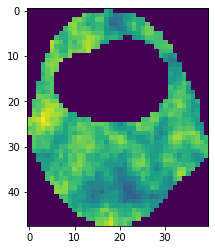

In [3]:
class Cell:
    """Class for generating a cell

    Raises:
        RuntimeError: When there is no way to position a nucleus within the
        cytoplasm

    Returns:
        Cell: self
    """
    # gamma_nucleus = 1.5
    # circ_nucleus = 2.5
    # gamma_cytoplasm = 1
    # circ_cytoplasm = 2
    # gamma_cytoplasm_texture = 1

    def __init__(self,  cytoplasm_size,
                        nucleus_size,
                        gamma_nucleus,
                        circ_nucleus,
                        gamma_cytoplasm,
                        circ_cytoplasm,
                        gamma_cytoplasm_texture,
                        lowest_intensity
                        ):
        """Cell generator, based on opensimplex noise generation

        Args:
            cytoplasm_size (int): radius of cytoplasm in pixels
            nucleus_size (int): radius of nucleus in pixels
            gamma_nucleus (float): noise parameter, defines the shape of nucleus. Typical values are between 0.5 and 1.5
            circ_nucleus (float): circularity of cytoplasm. Defines the shape of cytoplasm. Typical values are between 1 and 2
            gamma_cytoplasm (float): noise parameter, defines the shape of cytoplasm. Typical values are between 0.1 and 1.5
            circ_cytoplasm (float): circularity of cytoplasm. Defines the shape of cytoplasm. Typical values are between 1 and 3
            gamma_cytoplasm_texture (float): noise parameter, defines the frequency of cytoplasm texture. Typical values are between 0.01 and 2
        """
        self.size_cytoplasm = cytoplasm_size
        self.nucleus_size = nucleus_size

        self.gamma_nucleus = gamma_nucleus
        self.circ_nucleus = circ_nucleus
        self.gamma_cytoplasm = gamma_cytoplasm
        self.circ_cytoplasm = circ_cytoplasm
        self.gamma_cytoplasm_texture = gamma_cytoplasm_texture
        self.lowest_intensity = lowest_intensity

        self.mask_cytoplasm = None
        self.mask_nucleus = None
        self.texture_cytoplasm = None
        self.image = None

    def _normalize(self, arr):
        arr -= arr.min()
        arr /= arr.max()
        return arr

    def _shift(self,image, vector):
        tr = transform.AffineTransform(translation=vector)
        shifted = transform.warp(image, tr, preserve_range=True)
        shifted = shifted.astype(image.dtype)
        return shifted

    def run(self):
        self.generate_cytoplasm()
        self.generate_nucleus()
        self.position_nucleus()
        self.apply_texture()
        
    def generate_nucleus(self):
        NB = NoiseBlob(size=self.nucleus_size)
        self.mask_nucleus = NB.make_mask(self.gamma_nucleus, self.circ_nucleus)

    def generate_cytoplasm(self):
        NB = NoiseBlob(size=self.size_cytoplasm)
        self.mask_cytoplasm = NB.make_mask(self.gamma_cytoplasm, self.circ_cytoplasm)
        self.texture_cytoplasm = NB.make_texture(self.gamma_cytoplasm_texture)

    def position_nucleus(self):
        hc, wc = self.mask_cytoplasm.shape
        hn, wn = self.mask_nucleus.shape

        mask_nucleus = np.pad(self.mask_nucleus, ((0,hc-hn), (0,wc-wn)), 'constant', constant_values=0)

        terminator = 0
        while terminator <= 100:
            x = np.random.randint(0, wc-wn)
            y = np.random.randint(0, hc-hn)

            shifted = self._shift(mask_nucleus, (-y, -x))
            if np.all(self.mask_cytoplasm[shifted]):
                break
            else:
                terminator += 1
                if terminator == 100:
                    raise RuntimeError('Could not position nucleus, try to decrease nucleus size or increase cytoplasm size')

        self.mask_cytoplasm[shifted] = 0

    def apply_texture(self):
        self.image = np.zeros_like(self.texture_cytoplasm)
        self.image[self.mask_cytoplasm] = self.texture_cytoplasm[self.mask_cytoplasm] + self.lowest_intensity
        self.image = self._normalize(self.image)

c = Cell(   cytoplasm_size          = 20,
            nucleus_size            = 10,
            gamma_nucleus           = 1.5,
            circ_nucleus            = 2.5,
            gamma_cytoplasm         = 1.0,
            circ_cytoplasm          = 2.0,
            gamma_cytoplasm_texture = .05,
            lowest_intensity        = 0.4)
c.run()

fig, ax = plt.subplots(1,1)
ax.imshow(c.image)
        

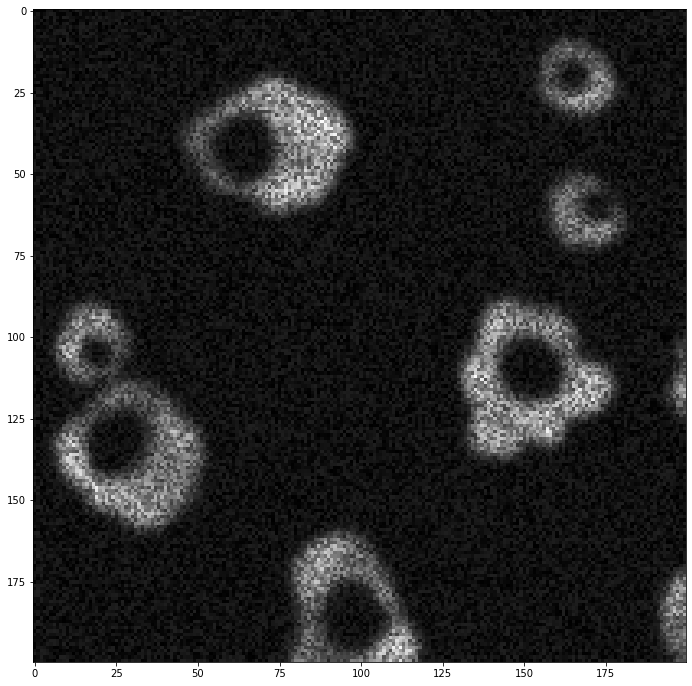

In [16]:
class Simulator:

    def __init__(self, shape, cell_number) -> None:
        self.image = np.zeros(shape)
        self.mask  = np.zeros(shape)
        self.shape = shape
        self.cell_number = cell_number
        self.sigma = 2
        self.noise_signal_level = 0.5
        self.noise_background_level = 0.2

        self.C1 = Cell(  
            cytoplasm_size          = 20,
            nucleus_size            = 10,
            gamma_nucleus           = 1.5,
            circ_nucleus            = 2,
            gamma_cytoplasm         = 0.5,
            circ_cytoplasm          = 2.0,
            gamma_cytoplasm_texture = .5,
            lowest_intensity        = 0.5)

        self.C2 = Cell(  
            cytoplasm_size          = 10,
            nucleus_size            = 5,
            gamma_nucleus           = 1.5,
            circ_nucleus            = 2.5,
            gamma_cytoplasm         = 1.0,
            circ_cytoplasm          = 2.0,
            gamma_cytoplasm_texture = .5,
            lowest_intensity        = 0.5)

    def normalize(func):
        def wrapper(self, *args, **kwargs):
            func(self, *args, **kwargs)
            self.image -= self.image.min()
            self.image /= self.image.max()
        return wrapper

    def run(self):
        self.populate()
        self.apply_filter()
        self.apply_noise()       
        return self.image

    def _expand(self, arr):
        h, w = self.shape
        py = (0, h - arr.shape[0])
        px = (0, w - arr.shape[1])
        arr = np.copy(arr)
        arr = np.pad(arr, (py, px), 'constant', constant_values=0)
        return arr

    def _shift(self, image, vector):
        tr = transform.AffineTransform(translation=vector)
        shifted = transform.warp(image, tr, preserve_range=True)
        shifted = shifted.astype(image.dtype)
        return shifted

    def position_cell(self, cell, pos):
        mask = self._expand(cell.mask_cytoplasm)
        mask = self._shift(mask, pos)
        return mask
    
    @normalize
    def apply_filter(self):
        self.image = filters.gaussian(self.image, sigma=self.sigma)

    @normalize
    def apply_noise(self):
        self.image *= (np.random.random(self.shape)+self.noise_signal_level)
        self.image += np.random.random(self.shape)*self.noise_background_level

    @normalize
    def populate(self):
        for i in range(self.cell_number):
            C = np.random.choice([self.C1, self.C2])
            C.run()
            terminate = 0
            while True:
                y = np.random.randint(0, self.shape[0])
                x = np.random.randint(0, self.shape[1])
                mask = self.position_cell(C, (-y, -x))
                if np.any(self.mask[mask]):
                    terminate += 1
                else:
                    image = self._expand(C.image)
                    image = self._shift(image, (-y, -x))
                    self.mask += mask
                    self.image[mask] = image[mask]
                    break
                if terminate == 100:
                    raise RuntimeError('Could not position cell, try to decrease cell size or increase simulation size')

sim = Simulator(shape=(200,200), cell_number=10)
sim.run()
plt.figure(figsize=(12,12))

plt.imshow(sim.image, cmap='gray'); plt.show()

        
           

# Noise generation

100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


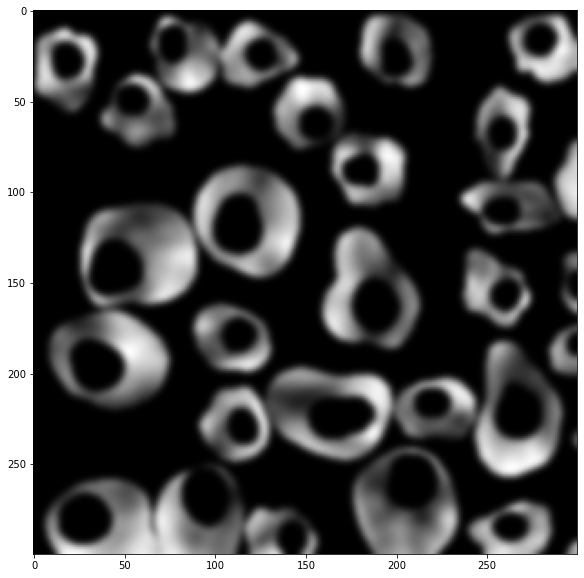

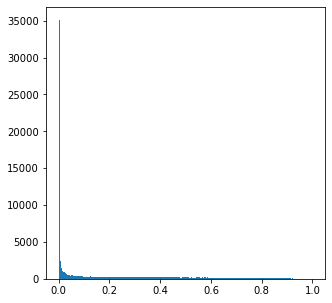

In [16]:
dx = dy = dz = 0.5
C1 = Cell(  
    size_cytoplasm          = 20,
    size_nucleus            = 10,
    dx = dx, dy = dy, dz = dz,
    gamma_nucleus           = 1.5,
    circ_nucleus            = 2,
    gamma_cytoplasm         = 0.5,
    circ_cytoplasm          = 2.0,
    gamma_cytoplasm_texture = .5,
    lowest_intensity        = 0.1)

C2 = Cell(  
    size_cytoplasm          = 30,
    size_nucleus            = 15,
    dx = dx, dy = dy, dz = dz,
    gamma_nucleus           = 1.5,
    circ_nucleus            = 2.5,
    gamma_cytoplasm         = 1.0,
    circ_cytoplasm          = 2.0,
    gamma_cytoplasm_texture = .5,
    lowest_intensity        = 0.1)

sim = Simulator(canvas_shape = (300,300),
                list_of_cells = [C1, C2],
                cell_number = 30,
                dx = dx, dy = dy, dz = dz,
                sigma = 2,
                noise_signal_level = 0.5,
                noise_background_level = 0.2)
sim.run();
plt.imshow(sim.image)
plt.figure(figsize=(5,5))
plt.hist(sim.image.flatten(), bins=256);

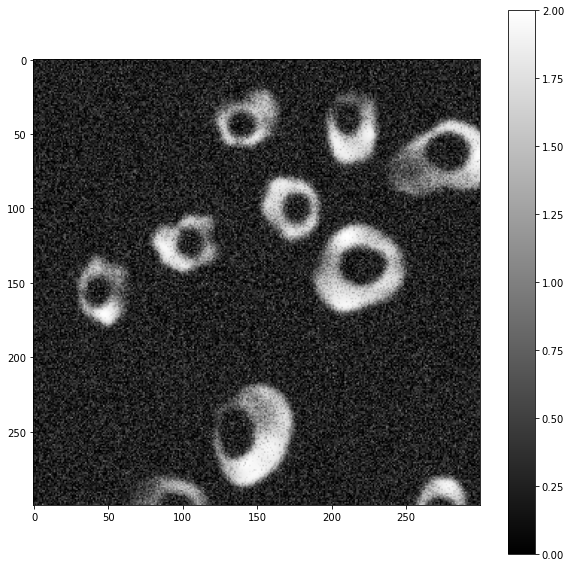

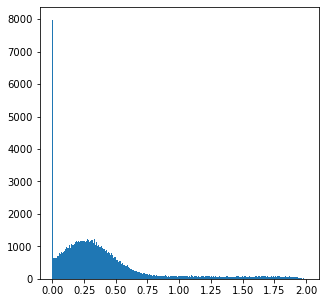

In [124]:
a = util.random_noise(sim.image, mode='gaussian', mean = 0.25, var = 0.04)
a = a+sim.image

plt.imshow(a)
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.hist(a.flatten(), bins=256);
    

## Search for best histogram

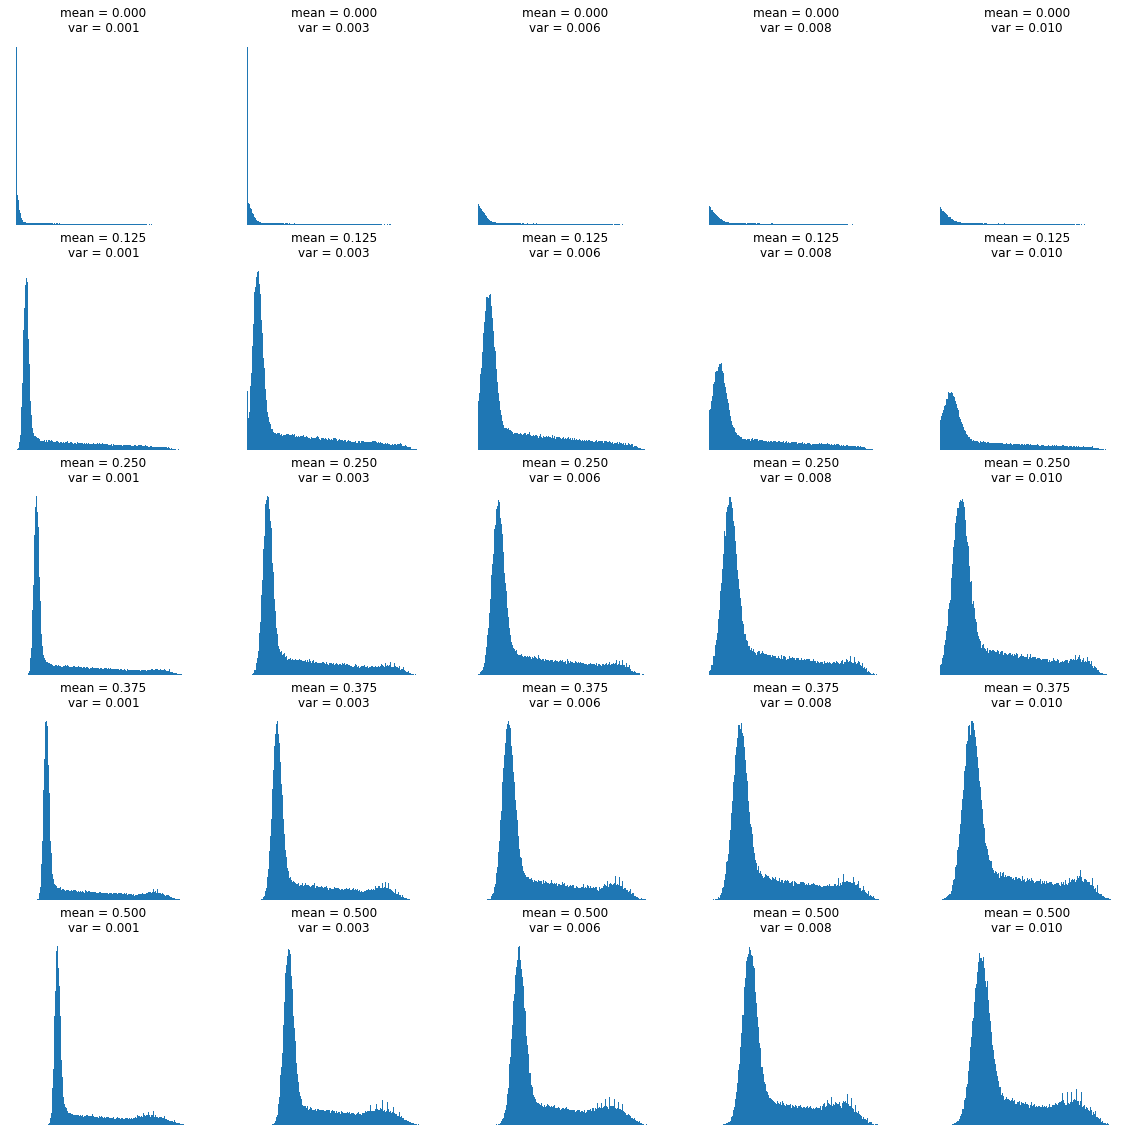

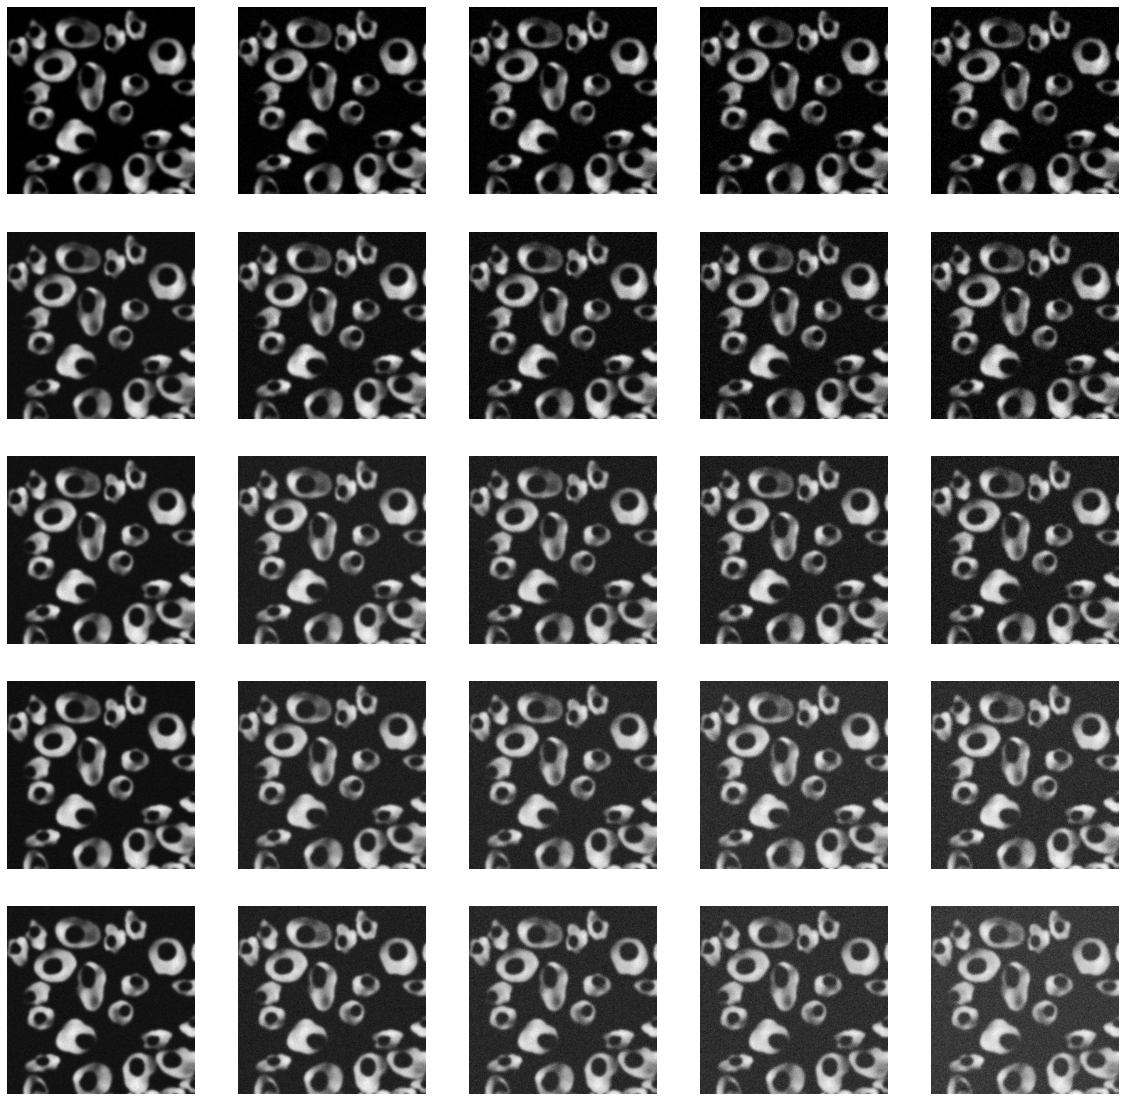

In [226]:
rows, cols = 5, 5

mean = np.linspace(0, .5, rows)
vari = np.linspace(0.001, 0.01, cols)

fig, ax = plt.subplots(rows, cols, figsize=(20,20))
figio, ai = plt.subplots(rows, cols, figsize=(20,20))

for r, m in enumerate(mean):
    for c, v in enumerate(vari):
        G = util.random_noise(sim.image, mode='gaussian', mean = m, var = v)
        P = np.random.poisson(sim.image*256) + G*256
        a = P
        ax[r,c].hist(a.flatten(), bins = np.linspace(0,a.max(),256));
        # ax[r,c].set_yscale('log')
        ai[r,c].imshow(a, cmap='gray')
        ai[r,c].axis('off')
        ax[r,c].set_title('mean = %.3f\nvar = %.3f' % (m, v))
        ax[r,c].axis('off')

(0.0, 2000.0)

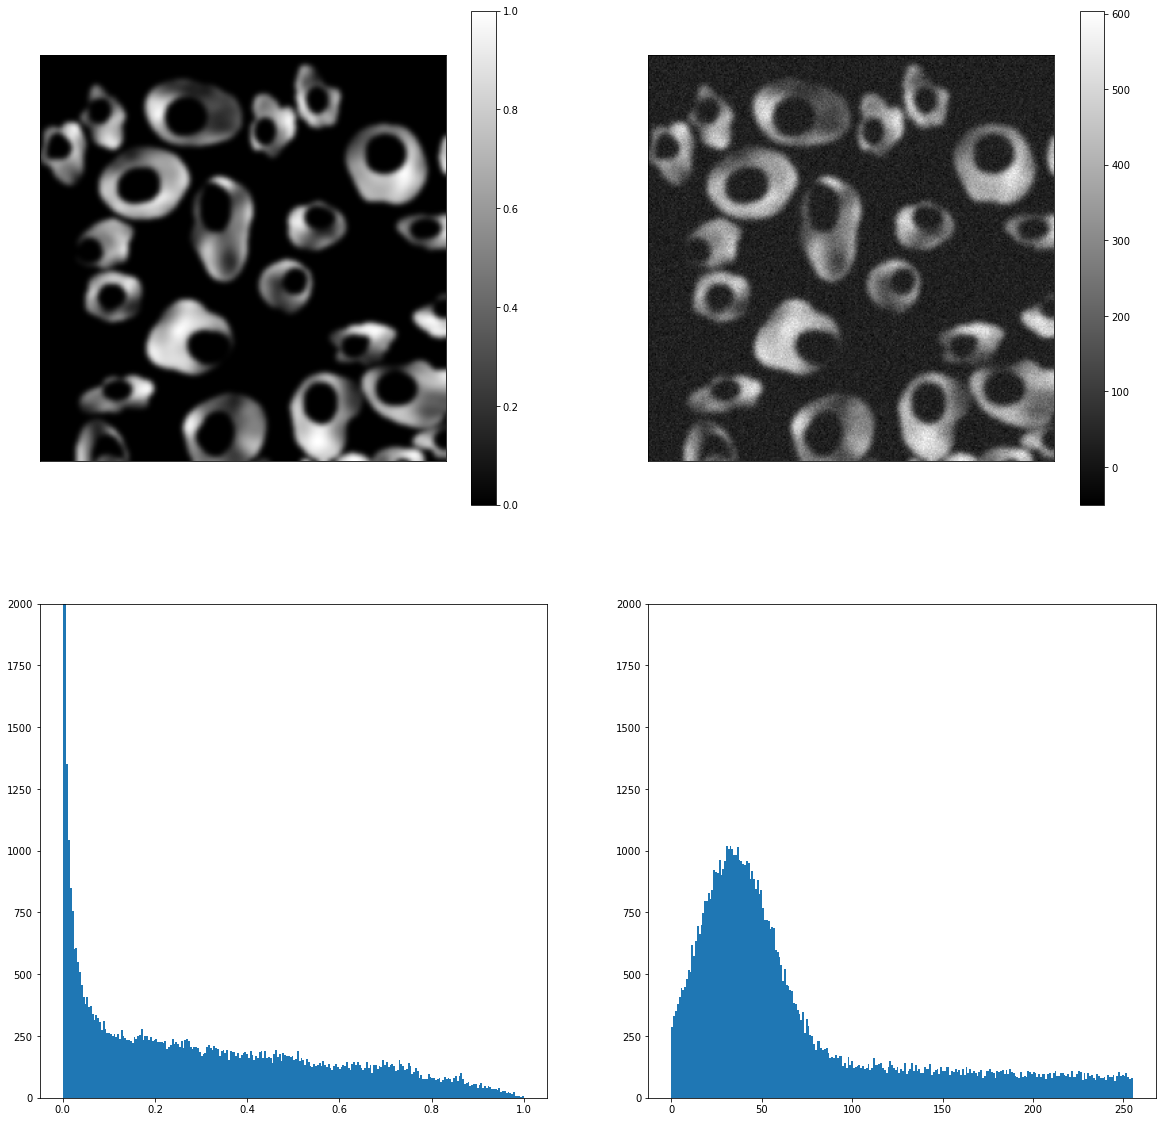

In [234]:
img = sim.image#[0:100,50:100]
G = util.random_noise(img*255, mode='gaussian', mean = 0.125, var = 0.007, clip=False)
# G = np.random.poisson(np.random.poisson(img*256))

# P =  G*255 + np.random.poisson(img*255)
fig = plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(img); plt.colorbar(); plt.xticks([]); plt.yticks([])
plt.subplot(2,2,2)
plt.imshow(P); plt.colorbar();plt.xticks([]); plt.yticks([])

plt.subplot(2,2,3)
plt.hist(img.flatten(), bins = np.linspace(0,img.max(),255)); plt.ylim([0,2000])
plt.subplot(2,2,4)
plt.hist(P.flatten(), bins = np.linspace(0,G.max(),255)); plt.ylim([0,2000])

1.0


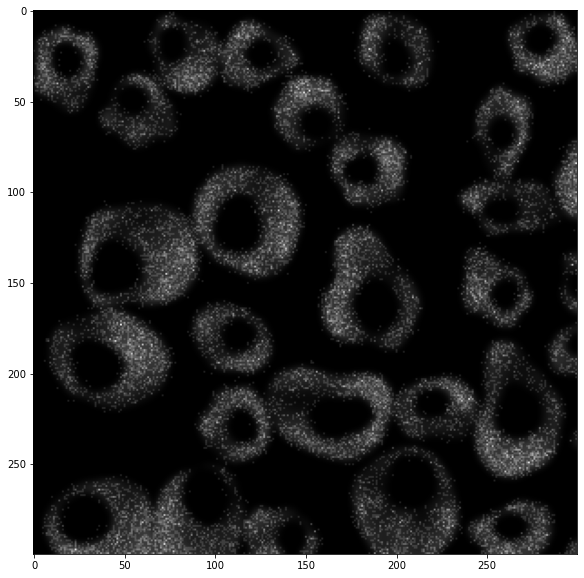

In [41]:
img = np.copy(sim.image)
print(img.max())
a = np.random.poisson(img)*0.5 + img
plt.imshow(a)

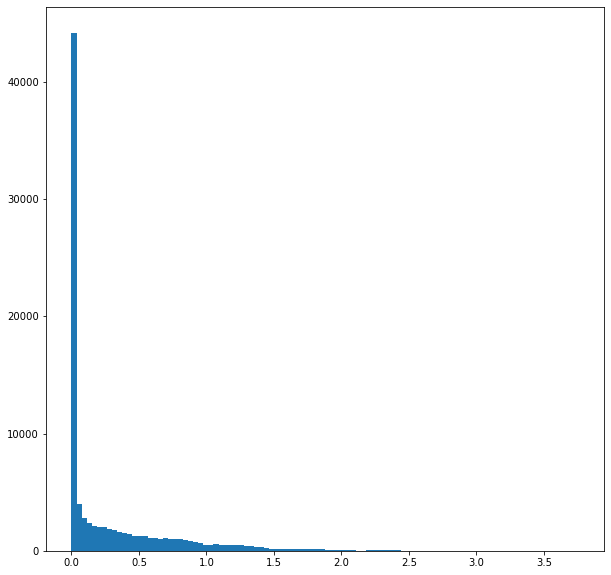

In [42]:
plt.hist(a.flatten(), bins=100);

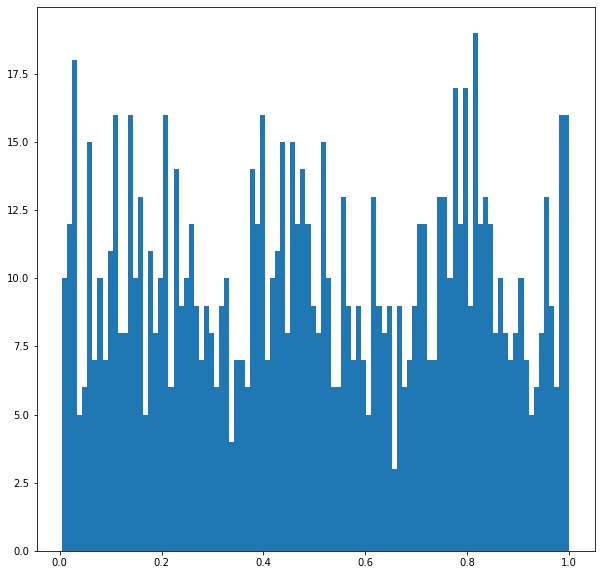

In [50]:
a = np.random.rand(1000)
plt.hist(a, bins=100);


# Create a polygon in polar coordinates

[2.0943951  4.1887902  6.28318531] [1.78191211 1.6339516  1.40887163]


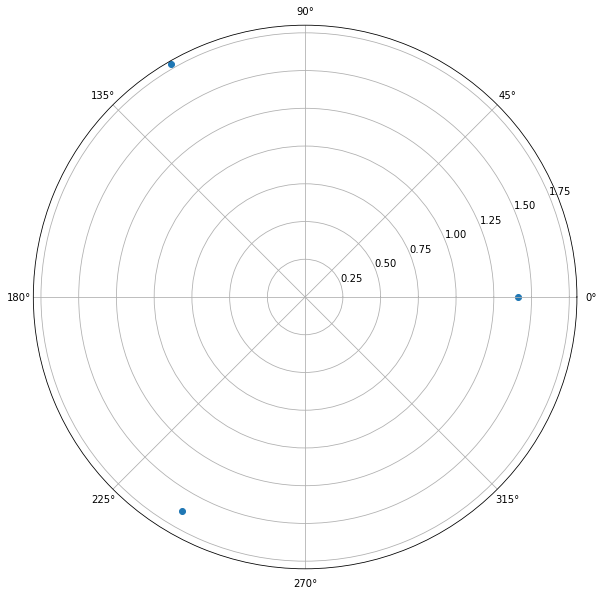

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

N = 3
p = 2*np.pi/N
theta = np.linspace(p, 2*np.pi - 2*np.pi/N+p, N)
r = 1+ np.random.random(N)
print(theta, r)
ax.scatter(theta, r)

## Cartesian
Line function in Cartesian:

$f(x) : ax+b = y$

To polar:

$r = \sqrt{x^2+y^2} \\ \theta = \arctg{y/x}$

To cartesian:

$x = r\cos{\theta} \\ y = r\sin{\theta}$

Solving for 2 points:

$(x_0,y_0);(x_1,y_1)$

## Polar
Line function in Polar: $F(\theta) : r = a\theta+b$

Solving for 2 points:

$ x = A^{-1}b :
\begin{pmatrix}
a \\ b
\end{pmatrix} =
\begin{pmatrix}
r_0 \cos{\theta_0} & 1 \\
r_1 \cos{\theta_1} & 1
\end{pmatrix} ^ {-1}
\begin{pmatrix}
r_0 \sin{\theta_0} \\ r_1 \sin{\theta_1}
\end{pmatrix}$

240.00000000000003 0.0
0.0 120.00000000000001
120.00000000000001 240.00000000000003


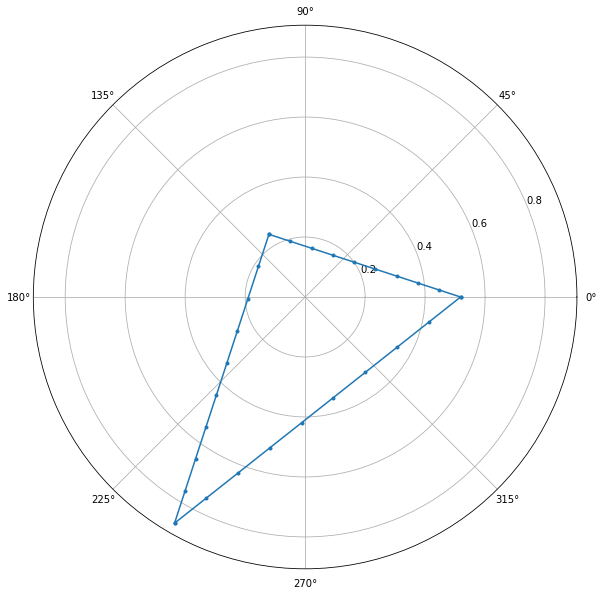

In [326]:
from re import S
from numpy import angle


def polar2cartesian(theta, r):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def cartesian2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return theta, r

def gen_polygon(N, angles, ax):
    sp = 10 # sampling_points
    # p = 0.1
    p = 0
    theta = np.linspace(p, p+2*np.pi - 2*np.pi/N, N)
    r = np.random.random(N)

    X = r*np.cos(theta)
    Y = r*np.sin(theta)
    RR = np.zeros(N * sp)
    TT = np.zeros(N * sp)
    for i in range(N):
        x0, x1 = X[i-1], X[i]
        y0, y1 = Y[i-1], Y[i]
        t0, t1 = theta[i-1], theta[i] 
        
        # Copmutation of the line from 2 points
        A = np.array([
            [x0, 1],
            [x1, 1],
        ])
        An = np.linalg.inv(A)
        b = np.array([y0, y1])
        a, b = np.dot(An, b)

        # Counting a line
        # That's a bad decision, way better to use original sampling in polar: # x = np.linspace(x0, x1, sp)
        x = np.linspace(x0, x1, sp)
        # alpha = angles[angles <]
        print(np.rad2deg(t0), np.rad2deg(t1))
        y = a * x + b
        T, R = cartesian2polar(x, y)
        TT[i*sp:(i+1)*sp] = T
        RR[i*sp:(i+1)*sp] = R

    # RR = np.interp(len(angles), len(RR), RR)
    return TT, RR

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
angles = np.linspace(0,2*np.pi,100)
a, polygon = gen_polygon(3, angles, ax)
ax.plot(a, polygon, '.-')
# polygon = np.interp(angles, a, polygon)
# ax.plot(np.rad2deg(angles), polygon)


[(0.6375719389044486, -0.5137451956872162), (-0.06917664963132365, 0.05574142968540611), (1.998458297762224, 0.12505090057054685)]


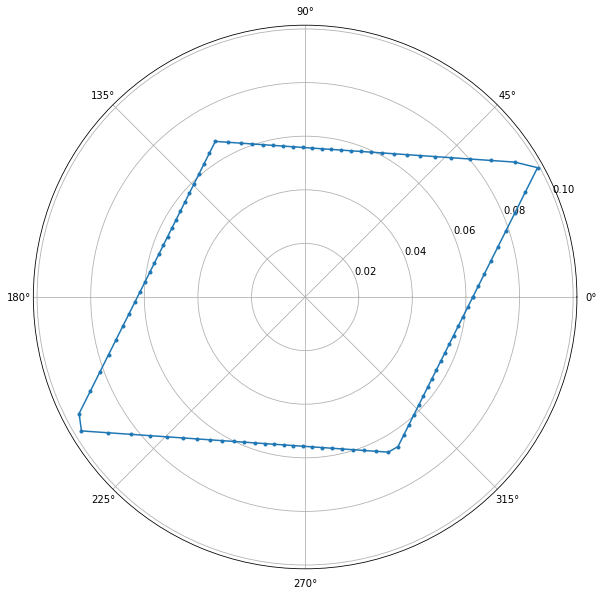

In [349]:
def gen_polygon(N, angles, ax):
    sp = 10 # sampling_points
    # p = 0.1
    p = 0
    theta = np.linspace(p, p+2*np.pi - 2*np.pi/N, N)
    r = np.random.random(N)

    X = r*np.cos(theta)
    Y = r*np.sin(theta)
    RR = np.zeros(N * sp)
    TT = np.zeros(N * sp)
    lines = []
    for i in range(N):
        x0, x1 = X[i-1], X[i]
        y0, y1 = Y[i-1], Y[i]
        t0, t1 = theta[i-1], theta[i] 
        
        # Copmutation of the line from 2 points
        A = np.array([
            [x0, 1],
            [x1, 1],
        ])
        An = np.linalg.inv(A)
        b = np.array([y0, y1])
        a, b = np.dot(An, b)
        lines.append((a, b))

    print(lines)

    R = []
    for i, alpha in enumerate(angles):
        rs = []
        for line in lines:
            a, b = line
            r = - b /(a*np.cos(alpha) - np.sin(alpha))
            rs.append(abs(r))
        R.append(min(rs))
        

            

    # RR = np.interp(len(angles), len(RR), RR)
    return angles, np.array(R)

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
angles = np.linspace(0,2*np.pi,100)
a, polygon = gen_polygon(3, angles, ax)
ax.plot(a, polygon, '.-')
# polygon = np.interp(angles, a, polygon)
# ax.plot(np.rad2deg(angles), polygon)


In [308]:
print(a.max() - a.min())
print(angles.max() - angles.min())

5.892455847339612
6.283185307179586


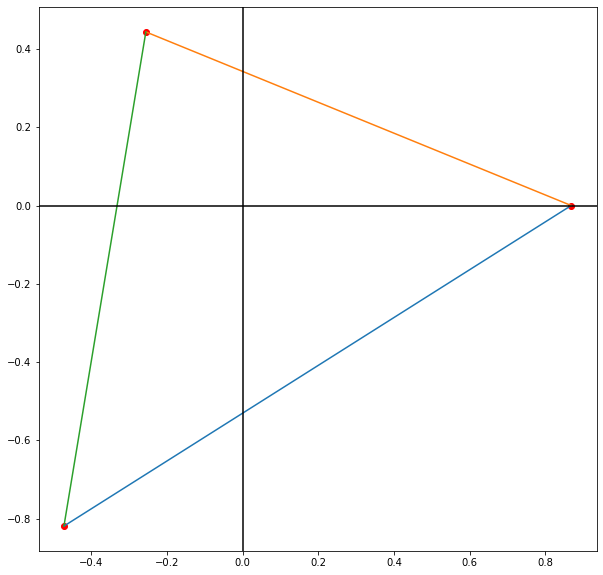

In [112]:
N = 3
theta = np.linspace(0, 2*np.pi - 2*np.pi/N, N)
r = np.random.random(N)

X = r*np.cos(theta)
Y = r*np.sin(theta)
RR = np.zeros(N*100)
TT = np.zeros(N*100)
for i in range(N):
    x0, x1 = X[i-1], X[i]
    y0, y1 = Y[i-1], Y[i]
    
    A = np.array([
        [x0, 1],
        [x1, 1],
    ])
    An = np.linalg.inv(A)
    b = np.array([y0, y1])
    a, b = np.dot(An, b)
    x = np.linspace(x0, x1, 100)
    y = a * x + b
    T, R = cartesian2polar(x, y)
    TT[i*100:(i+1)*100] = T
    RR[i*100:(i+1)*100] = R
    plt.plot(x, y)

plt.axvline(color='black')
plt.axhline(color='black')
plt.scatter(X, Y, color='red')


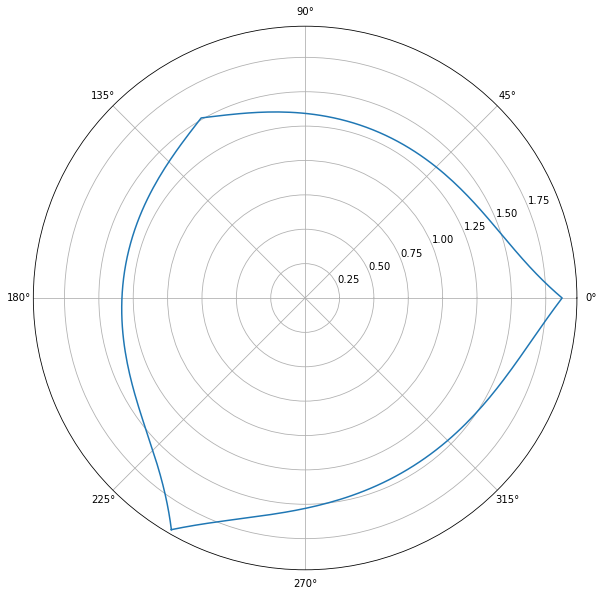

In [113]:
fig = plt.figure()
ax  = fig.add_subplot(111, projection='polar')
one = np.ones_like(RR)
ax.plot(TT, RR+one)

## Solution for sampling issue

[2.82842712 1.62330968 1.19543396 1.         0.91296241 0.89603695
 0.94280904 1.07179677 1.34810504 2.        ]


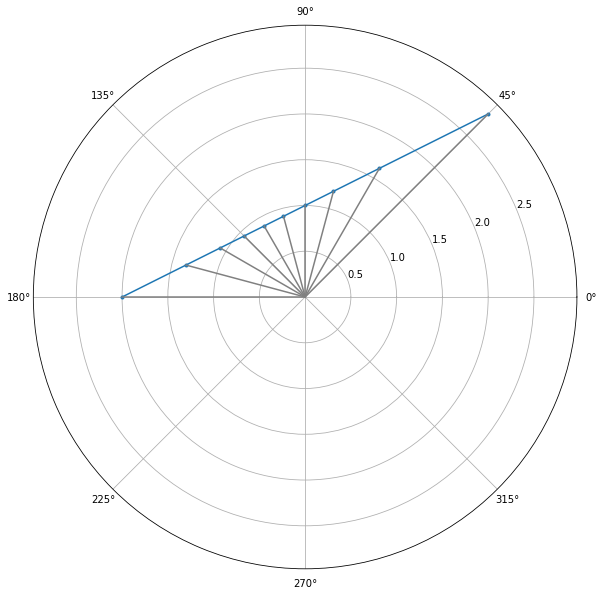

In [350]:
theta = np.linspace(np.pi/4, np.pi, 10)
a = 0.5
b = 1
r = - b /(a*np.cos(theta) - np.sin(theta))

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.plot(theta, r, '.-')
print(r)
for i in range(10):
    R = [0, r[i]]
    T = [theta[i], theta[i]]
    ax.plot(T, R, c='gray')

# Spherical coordinates move to 3D

In [3]:
def spherical2cartesian(R, T, P):
    x = R * np.cos(T) * np.sin(P)
    y = R * np.sin(T) * np.sin(P)
    z = R * np.cos(P)
    return x, y, z

def cartesian2spherical(x, y, z):
    R = np.sqrt(x**2 + y**2 + z**2)
    T = np.arctan2(y, x)
    P = np.arccos(z/R)
    return R, T, P

x = np.linspace(0,10,100)
y = np.linspace(0,10,100)
z = np.linspace(0,10,100)
# X, Y, Z = np.meshgrid(x, y, z)
noise = opensimplex.noise3array(x, y, z)
np.save('noise3d.npy', noise)

In [100]:
from pytest import MonkeyPatch


class NoiseBlob3D:
    default_size = 10
    def __init__(self, size):
        self.size = size

        self.mask = None
        self.texture = None

    def make_mask(self, gamma, circularity):
        contour, T, P = self.generate_contour(gamma, circularity)
        self.mask = self.generate_blob(contour, T, P).astype(bool)
        return self.mask

    def make_texture(self, gamma):
        if type(self.mask) == None: raise RuntimeError('Mask is not generated')
        self.texture = np.zeros(self.mask.shape)
        noise = self.generate_noise(self.mask.shape, gamma)
        noise -= noise.min()
        noise /= noise.max()
        self.texture[self.mask] = noise[self.mask]
        return self.texture

    def fill_contours(self, arr):
        return np.maximum.accumulate(arr, 1) * \
            np.maximum.accumulate(arr[:, ::-1], 1)[:, ::-1] * \
            np.maximum.accumulate(arr[::-1, :], 0)[::-1, :] * \
            np.maximum.accumulate(arr, 0)

    def generate_blob(self, contour, T, P):
        # Generate a mask
        i, j, k = spherical2cartesian(contour, T, P)
        i *= self.size
        j *= self.size
        k *= self.size

        i -= i.min()
        j -= j.min()
        k -= k.min()

        i = i.astype(int)
        j = j.astype(int)
        k = k.astype(int)

        h = (i.max() + 1).astype(int)
        w = (j.max() + 1).astype(int)
        d = (k.max() + 1).astype(int)

        mask = np.zeros([h, w, d])
        mask[i, j, k] = 1
        mask = self.fill_contours(mask)
        self.mask = mask

        return mask


    def generate_contour(self, gamma, circularity):
        # Creating a noise domain
        N = 100
        sampling_mult = 2
        A = self.generate_noise((N, N, N), gamma)

        # Sampling from noise domain
        c = N//2
        r = N//2-1
        t = np.linspace(0,np.pi,N*sampling_mult) # NOTE: Increase number of points, if there is a stringing artifact
        p = np.linspace(0,2*np.pi,N*sampling_mult) # NOTE: Increase number of points, if there is a stringing artifact
        r = np.ones_like(t) * r
        R, T, P = np.meshgrid(r, t, p)

        x, y, z = spherical2cartesian(R, T, P)
        x = (x + c).astype(int)
        y = (y + c).astype(int)
        z = (z + c).astype(int)
        noise_patch = A[x, y, z]

        # Adding noise to circle contour with weight circularity
        fundamental_mode = np.ones_like(noise_patch) * circularity
        contour = fundamental_mode + noise_patch
        contour /= contour.max()
        return contour, T, P

    def generate_noise(self, shape, gamma):
        N = max(shape)
        A = np.zeros(shape)
        # np.random.seed(5)
        for i in range(50):
            p = np.random.rand()*N*1.5
            y = np.linspace(p, p + i, shape[0])
            x = np.linspace(p, p + i, shape[1])
            z = np.linspace(p, p + i, shape[2])
            a = opensimplex.noise3array(x, y, z)*np.exp(-i*gamma)
            A += a

        A /= np.abs(A).max()
        return A


NB3D = NoiseBlob3D(30)
mask = NB3D.make_mask(1, 1)
# mask = np.pad(mask, 5, 'constant', constant_values=0)

# maskf = morphology.dilation(mask, morphology.ball(5))
# maskf = morphology.erosion(maskf, morphology.ball(5))







In [101]:
viewer = napari.viewer.Viewer()
viewer.add_image(mask, name='before', colormap='red', blending='additive')
# viewer.add_image(maskf, name='after', colormap='green', blending='additive')



<Image layer 'before' at 0x7fd9e4893750>

In [71]:
viewer = napari.viewer.Viewer()
viewer.add_image(NB3D.A, name='noise', colormap='gray', blending='additive')

<Image layer 'noise' at 0x7fd9e3c043d0>

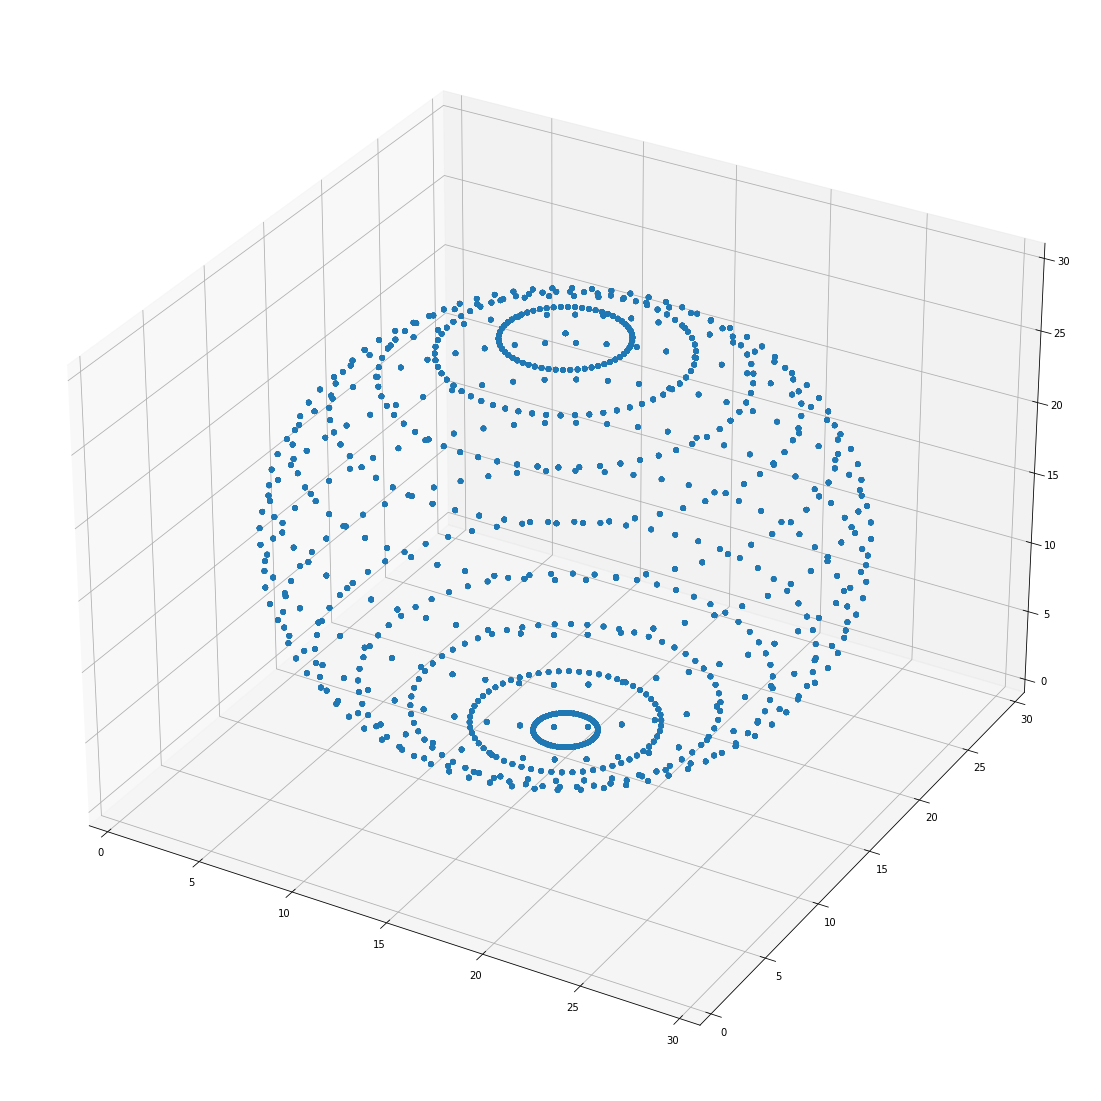

In [30]:
N = 30
r = N//2-1
c = N//2
t = np.linspace(0,np.pi,N) # NOTE: Increase number of points, if there is a stringing artifact
p = np.linspace(0,2*np.pi,N) # NOTE: Increase number of points, if there is a stringing artifact
r = np.ones_like(t)*r
R, T, P = np.meshgrid(r, t, p)

x, y, z = spherical2cartesian(R, T, P)
x += c; y += c; z += c
# x = x.astype(int)
# y = y.astype(int)
# z = z.astype(int)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z);

In [28]:
A = NB3D.generate_noise((N, N, N), 1)
B = np.zeros((N, N, N))
B[y, x, z] = A[y, x, z]

In [29]:
np.save('blob3d.npy', B)